# Actividad 2 - Estudio sobre remesas

Leemos los datos.

In [1]:
library(readxl)
if (.Platform$OS.type=="unix"){ ruta_excel <- "datasets/Envios.xlsx"
} else ruta_excel <- "../datasets/Envios.xlsx"
datos_remesas<-suppressMessages(read_excel(ruta_excel, sheet="envios"))
head(datos_remesas, n=3)

genero,lug_naci,edocivil,trabajo,envio_,envios_cat
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
MASCULINO,ZONA CENTRO,SOLTERO,INDUSTRIA,0,No envia
MASCULINO,ZONA NORTE,SOLTERO,INDUSTRIA,0,No envia
MASCULINO,ZONA NORTE,SOLTERO,T. SERV PUB / PERSONAL,0,No envia


Codificamos la variable envios_cat como 1 y 0, para calcular la regresión logística.

In [2]:
suppressPackageStartupMessages(library(dplyr))
datos_remesas %>%
    mutate(envia_dinero = ifelse(envios_cat=="Si envia", 1, 0)) %>%
    select(everything(), -envios_cat) -> remesas_catenvia

Calculamos la regresión lineal:

De la tabla anterior vemos que la variable que más contribuye al modelo es el género.

In [3]:
mi_lm <- lm(
    data=remesas_catenvia,    
    formula=envio_~genero+lug_naci+edocivil+trabajo    
)

summary(mi_lm)$coeff

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),165.3723772,51.82650,3.19088433,0.001440812
generoMASCULINO,134.3147504,43.79587,3.06683574,0.002192930
lug_naciZONA NORTE,-13.6222404,27.85086,-0.48911387,0.624815782
lug_naciZONA SURESTE,12.8591453,68.76999,0.18698773,0.851689593
lug_naciZONA TRADICIONAL,-16.6218346,25.59230,-0.64948575,0.516100519
edocivilSOLTERO,-0.7271453,21.42283,-0.03394254,0.972926426
trabajoCOMERCIO,-74.8868244,56.83902,-1.31752493,0.187816637
trabajoINDUSTRIA,-15.0731142,21.63979,-0.69654617,0.486169405
trabajoT. SERV PUB / PERSONAL,-31.0750162,25.56289,-1.21563000,0.224272224
trabajoTECNICO ADMVO,45.4854231,56.46143,0.80560176,0.420570185


Revisamos $R^2$ para ver qué tan preciso es el modelo:

In [4]:
summary(mi_lm)$r.squared

[1] 0.007962904

Vemos que el modelo no explica correctamente los datos. Mejor lo mandamos a dormir a su camita.

## Regresión logística múltiple

Como el modelo de regresión lineal no explica la variable que se quiere medir, probamos con la regresión logística.

En este caso, como la regresión logística en R toma los primeros valores en la tabla como las categorías de referencia, convertimos las variables a factores y establecemos las categorías de referencia:

In [5]:
remesas_catenvia$genero <- relevel(as.factor(remesas_catenvia$genero), ref = "FEMENINO")
remesas_catenvia$edocivil <- relevel(as.factor(remesas_catenvia$edocivil), ref = "CASADO O UNIDO")
remesas_catenvia$trabajo <- relevel(as.factor(remesas_catenvia$trabajo), ref = "COMERCIO")
remesas_catenvia$lug_naci <- relevel(as.factor(remesas_catenvia$lug_naci), ref = "ZONA NORTE")

Calculamos la regresión logística:

In [6]:
mi_glm <- glm(
    data=remesas_catenvia,
    formula=envia_dinero~genero+lug_naci+edocivil+trabajo,
    # Por qué no se toma en cuenta el envío de $?
    family = binomial(link = "logit"),
    # Para aumentar # de iteraciones si el modelo no converge
    control = list(maxit = 50)
)

Graficamos la razón de momios para ver cómo se comporta el modelo de regresión logística calculado:

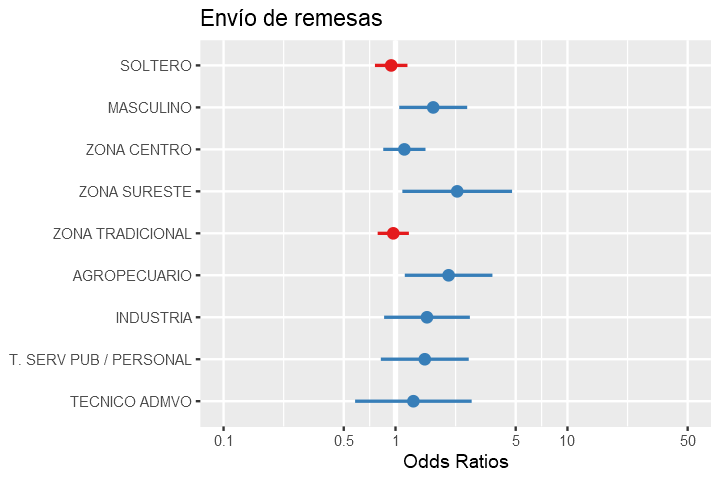

In [7]:
suppressPackageStartupMessages(library(sjPlot))
options(repr.plot.width=6, repr.plot.height=4)
plot_model(mi_glm, title="Envío de remesas")

Revisamos los valores que nos regresa el modelo:

In [8]:
coeficientes <- summary(mi_glm)$coeff
# los datos que nos regresa el modelo está expresado en _logitos_, lo convertimos a momios
cbind(coeficientes, odd_ratio = exp(coeficientes[,1]))

,Estimate,Std. Error,z value,Pr(>|z|),odd_ratio
(Intercept),-0.87070681,0.3597201,-2.4205119,0.01549867,0.4186555
generoMASCULINO,0.50475915,0.2321881,2.1739232,0.02971091,1.6565865
lug_naciZONA CENTRO,0.11861675,0.1443890,0.8215082,0.41135683,1.1259383
lug_naciZONA SURESTE,0.82612933,0.3747947,2.2042183,0.02750899,2.2844592
lug_naciZONA TRADICIONAL,-0.02997358,0.1066931,-0.2809327,0.77876204,0.9704712
edocivilSOLTERO,-0.05778392,0.1110888,-0.5201599,0.60295214,0.9438539
trabajoAGROPECUARIO,0.71095194,0.2993416,2.3750522,0.01754647,2.0359284
trabajoINDUSTRIA,0.42149177,0.2929295,1.4388849,0.15018314,1.5242337
trabajoT. SERV PUB / PERSONAL,0.39198584,0.3003226,1.3052158,0.19181938,1.4799168
trabajoTECNICO ADMVO,0.23937193,0.3982126,0.6011159,0.54776282,1.2704510


In [9]:
# Otra opción que aprendí en la siguiente tarea es
library(broom)
tidy(mi_glm, conf.int = TRUE, conf.level = 0.95, exponentiate = TRUE)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.4186555,0.3597201,-2.4205119,0.01549867,0.2041727,0.840199
generoMASCULINO,1.6565865,0.2321881,2.1739232,0.02971091,1.0562985,2.632293
lug_naciZONA CENTRO,1.1259383,0.1443890,0.8215082,0.41135683,0.8486610,1.495126
lug_naciZONA SURESTE,2.2844592,0.3747947,2.2042183,0.02750899,1.1224646,4.948907
lug_naciZONA TRADICIONAL,0.9704712,0.1066931,-0.2809327,0.77876204,0.7871680,1.196062
edocivilSOLTERO,0.9438539,0.1110888,-0.5201599,0.60295214,0.7591781,1.173687
trabajoAGROPECUARIO,2.0359284,0.2993416,2.3750522,0.01754647,1.1389389,3.705161
trabajoINDUSTRIA,1.5242337,0.2929295,1.4388849,0.15018314,0.8636108,2.740751
trabajoT. SERV PUB / PERSONAL,1.4799168,0.3003226,1.3052158,0.19181938,0.8263734,2.698443


De la tabla anterior vemos que las variables que más significativas para el modelo son género masculino, lugar de nacimiento en zona sureste y el trabajo agropecuario.

Los odds ratio también pueden ser llamados coeficientes exponenciados.

**Para interpretar los momios se usa la siguiente regla:**

  • Si b = 0, el momio y la probabilidad son lo mismo a todos los niveles de x $\left( e^b=1 \right)$  
  • Si b > 0 , el momio y la probabilidad se incrementan al incrementar x $(e^b>1)$  
  • Si b < 0 , el momio y la probabilidad disminuyen al aumentar x $(e^b<1)$  
 

De la columna _odds_ratio_ vemos que la razón de posibilidades para que una persona envíe una remesa, se incrementan en las siguientes condiciones:

  - Si el género es masculino. En este caso, si el género es masculino(1.6565865), aumenta en un 65% la posibilidad de que envíe dinero en comparación del _género femenino_.
  - O si la persona nació en la zona centro o sureste a comparación de la zona norte.
  - O si tiene algún trabajo que no sea comercio.

Y disminuyen en las siguientes condiciones:

  - Si el lugar de nacimiento es _zona tradicional_
  - Si la persona es _soltera_. En este caso, si la persona es soltera (0.9438539) disminuye 6% la posibilidad de que envíe dinero en comparación con las personas de _edo civil casados o unidos_.

\*Nótese que estas condiciones se basan en el principio **Ceteris Paribus** que asume que sólo una categoría cambia mientras todas las demás categorías permanecen con un valor constante.

Para la combinación entre las categorías, se necesita hacer otra prueba.

Por ejemplo, para predecir la probabilidad de que un hombre migrante nacido en la zona centro, soltero y trabajando en la rama agropecuaria envíe remesa:

In [10]:
# Para predecir la probabilidad con algunas interacciones de los datos
plogis(predict(mi_glm, newdata = data.frame(genero="MASCULINO", lug_naci="ZONA CENTRO", edocivil="SOLTERO", trabajo = "AGROPECUARIO"), type = "response"))

1 
0.6456767

Hacemos las pruebas de hipótesis para las variables:

$H_{0}$: $\beta_{1}=...=\beta_{n}= 0$

$H_{a}$: No existe $\beta_{n} = 0$

In [11]:
anova(object=mi_glm, test="Chisq")
#Anova(mi_glm, type="II" test="LR")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,1970,2727.996,NA
genero,1,7.521982,1969,2720.474,0.006095059
lug_naci,3,6.455577,1966,2714.019,0.091430989
edocivil,1,0.410413,1965,2713.608,0.521759957
trabajo,4,11.738789,1961,2701.870,0.019403176


Al revisar los valores _p_, vemos que en el caso del _estado civil_ tenemos un valor bastante alto y por lo tanto, no se tiene evidencia estadística para rechazar la hipótesis nula. Esto significa que no todas las variables tienen una aportación significativa al modelo.

Adicionalmente calculamos los intervalos de convianza para la razón de momios:

In [12]:
suppressPackageStartupMessages(library(MASS))
suppressMessages(exp(confint(mi_glm)))

,2.5 %,97.5 %
(Intercept),0.2041727,0.840199
generoMASCULINO,1.0562985,2.632293
lug_naciZONA CENTRO,0.8486610,1.495126
lug_naciZONA SURESTE,1.1224646,4.948907
lug_naciZONA TRADICIONAL,0.7871680,1.196062
edocivilSOLTERO,0.7591781,1.173687
trabajoAGROPECUARIO,1.1389389,3.705161
trabajoINDUSTRIA,0.8636108,2.740751
trabajoT. SERV PUB / PERSONAL,0.8263734,2.698443
trabajoTECNICO ADMVO,0.5823527,2.788235


Los valores anteriores se pueden interpretar como:

  • Si el intervalo esta sobre 1, se concluye que existe asociación positiva  
  • Si el intervalo está bajo 1, se concluye que existe asociación negativa  
  • Si el intervalo contiene al 1, no se puede concluir que existe asociación

De lo anterior se puede concluir que:

  - Se puede afirmar que hay asociación positiva en las siguientes variables:  
    - Trabajo agropecuario, lugar nacimiento zona sureste, género masculino  
  - No se puede afirmar que hay asociación en las siguientes variables:  
    - Trabajos técnico administrativo, serv. público/ personal, industria, estado civil soltero, lugar nacimiento zona tradicional, zona centro.   

<hr>

# Actualización después de la clase:

Como en los ejercicios anteriores, podemos ver cómo se comportan los datos haciendo tablas de contingencia:

In [13]:
as.data.frame.matrix( # Esto es para poder convertir la salida de xtabs a formato bonito
    addmargins(xtabs(formula=~trabajo+lug_naci, data=remesas_catenvia))
)

,ZONA NORTE,ZONA CENTRO,ZONA SURESTE,ZONA TRADICIONAL,Sum
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
COMERCIO,22,8,2,20,52
AGROPECUARIO,80,97,9,364,550
INDUSTRIA,327,121,15,411,874
T. SERV PUB / PERSONAL,159,65,8,210,442
TECNICO ADMVO,16,9,2,26,53
Sum,604,300,36,1031,1971


Para probar el modelo, necesitamos revisar la interacción entre las variables. Para eso primero se hace la regresión lineal con el _modelo saturado_. Esto no siempre se tiene que hacer:

\*Nota: El error "not defined because of singularities" ocurre cuando hay alta correlación entre las variables independientes.

In [14]:
mi_glm_saturado <- suppressWarnings(glm(
    data=remesas_catenvia,
    # En la fórmula "*" significa la interacción entre las variables
    formula=envia_dinero~genero*lug_naci*edocivil*trabajo,
    family = binomial(link = "logit"),
    # Para aumentar # de iteraciones si el modelo no converge
    control = list(maxit = 1000)
))

In [15]:
suppressPackageStartupMessages(library(stargazer))
stargazer(mi_glm_saturado, type="text")
#library(broom)
#tidy(mi_glm_saturado)


                                                                                            Dependent variable:     
                                                                                       -----------------------------
                                                                                               envia_dinero         
--------------------------------------------------------------------------------------------------------------------
generoMASCULINO                                                                        -1,905,369,039,748,361.000***
                                                                                             (50,972,841.000)       
                                                                                                                    
lug_naciZONA CENTRO                                                                    -1,546,496,308,759,183.000***
                                                               

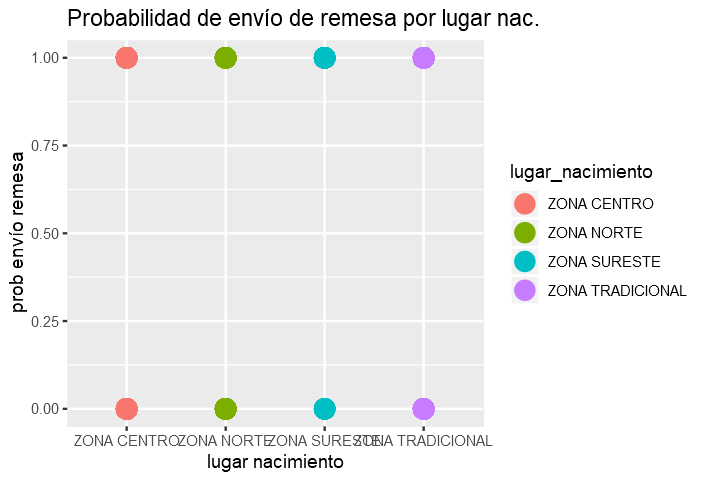

In [16]:
library(ggplot2)
datos_predichos <- data.frame(
    prob_env_remesa=mi_glm_saturado$fitted.values,
    lugar_nacimiento=datos_remesas$lug_naci)
 
ggplot(data=datos_predichos, aes(x=lugar_nacimiento, y=prob_env_remesa)) +
    geom_point(aes(color=lugar_nacimiento), size=5) +
    xlab("lugar nacimiento") +
    ylab("prob envío remesa") +
    ggtitle("Probabilidad de envío de remesa por lugar nac.")

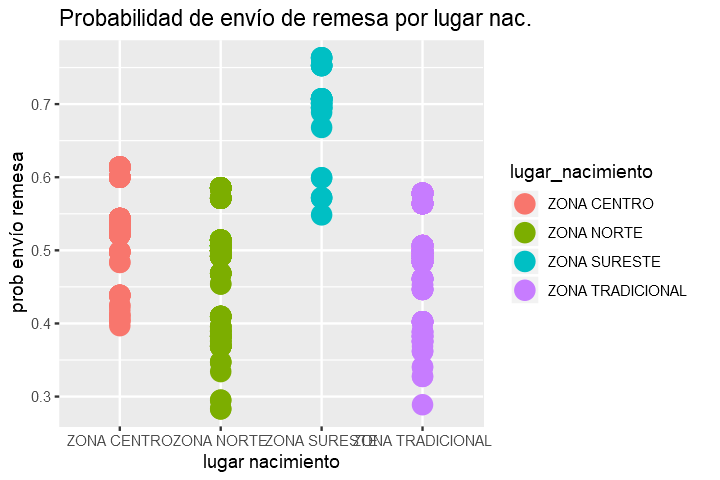

In [17]:
library(ggplot2)
datos_predichos <- data.frame(
    prob_env_remesa=mi_glm$fitted.values,
    lugar_nacimiento=datos_remesas$lug_naci)
 
ggplot(data=datos_predichos, aes(x=lugar_nacimiento, y=prob_env_remesa)) +
    geom_point(aes(color=lugar_nacimiento), size=5) +
    xlab("lugar nacimiento") +
    ylab("prob envío remesa") +
    ggtitle("Probabilidad de envío de remesa por lugar nac.")

Como vimos en la salida del comando stargazer, los valores del modelo saturado son muy grandes y hay problemas al extraerlos 😭

In [18]:
coef_modelo <- coef(summary(mi_glm_saturado))

df_summary <- cbind(interaccion = rownames(coef_modelo), as.data.frame.matrix(coef_modelo))
df_summary %>%
    mutate(ind_significancia =
        case_when(`Pr(>|z|)` <= 0.1 & `Pr(>|z|)` > 0.05 ~ '.',
                  `Pr(>|z|)` <= 0.05 & `Pr(>|z|)` > 0.01 ~ '*',
                  `Pr(>|z|)` <= 0.01 & `Pr(>|z|)` > 0.001 ~ '**',
                  `Pr(>|z|)` <= 0.001 & `Pr(>|z|)` >=0 ~ '***',
                  is.na(`Pr(>|z|)`) ~ '',
                  TRUE ~ ''
        )
    ) %>% head(n=5)

interaccion,Estimate,Std. Error,z value,Pr(>|z|),ind_significancia
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),2.251800e+15,47453133,47453132,0,***
generoMASCULINO,-1.905369e+15,50972841,-37380083,0,***
lug_naciZONA CENTRO,-1.546496e+15,54649056,-28298683,0,***
lug_naciZONA SURESTE,-1.892741e+14,141115820,-1341268,0,***
lug_naciZONA TRADICIONAL,-6.755399e+15,82191237,-82191235,0,***


Con el código generado por R commander

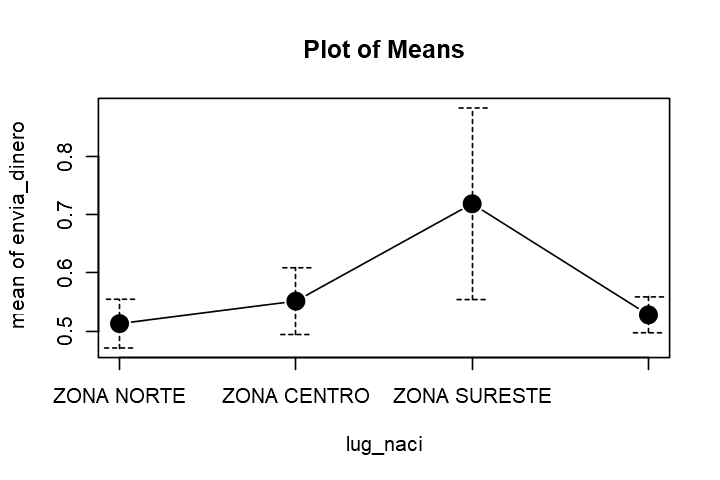

In [19]:
suppressPackageStartupMessages(library(Rcmdr))
with(remesas_catenvia[remesas_catenvia$genero=="MASCULINO",], plotMeans(envia_dinero, lug_naci, error.bars="conf.int", level=0.95, connect=TRUE, legend.pos="bottom"))

In [20]:
library(car)
suppressWarnings(Anova(mi_glm_saturado, type="II", test="LR"))

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
genero,5.695566,1,1.700783e-02
lug_naci,6.463259,3,9.112280e-02
edocivil,1513.833442,1,0.000000e+00
trabajo,11.724304,4,1.952360e-02
genero:lug_naci,3.465547,3,3.252582e-01
genero:edocivil,720.873068,1,8.645946e-159
lug_naci:edocivil,576.698454,3,1.134194e-124
genero:trabajo,1.202498,4,8.776872e-01
lug_naci:trabajo,25.290120,12,1.350636e-02


In [21]:
mi_glm_trln <- glm(
    data=remesas_catenvia,
    # En la fórmula "*" significa la interacción entre las variables
    formula=envia_dinero~genero+edocivil+lug_naci*trabajo,
    family = binomial(link = "logit"),
    # Para aumentar # de iteraciones si el modelo no converge
    control = list(maxit = 1000)
)


coef_modelo <- coef(summary(mi_glm_trln))

df_summary <- cbind(interaccion = rownames(coef_modelo), as.data.frame.matrix(coef_modelo))
df_summary %>%
    mutate(ind_significancia =
        case_when(`Pr(>|z|)` <= 0.1 & `Pr(>|z|)` > 0.05 ~ '.',
                  `Pr(>|z|)` <= 0.05 & `Pr(>|z|)` > 0.01 ~ '*',
                  `Pr(>|z|)` <= 0.01 & `Pr(>|z|)` > 0.001 ~ '**',
                  `Pr(>|z|)` <= 0.001 & `Pr(>|z|)` >=0 ~ '***',
                  is.na(`Pr(>|z|)`) ~ '',
                  TRUE ~ ''
        )
    ) %>%
    filter(ind_significancia != "")

interaccion,Estimate,Std. Error,z value,Pr(>|z|),ind_significancia
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
generoMASCULINO,0.5904675,0.2402963,2.457247,0.01400062,*
lug_naciZONA CENTRO,-2.0557803,1.1528039,-1.783287,0.07453957,.
lug_naciZONA CENTRO:trabajoAGROPECUARIO,2.0785481,1.1938597,1.741032,0.08167795,.
lug_naciZONA CENTRO:trabajoINDUSTRIA,2.5142841,1.1728819,2.143681,0.03205849,*


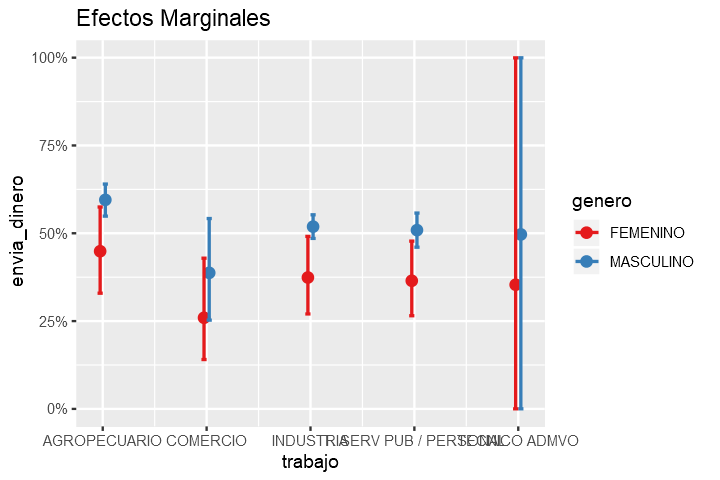

In [22]:
# plot_model(mi_glm_trln, type = "int")

plot_model(mi_glm_trln, type = "eff", terms=c("trabajo", "genero"), title="Efectos Marginales")

Nota sobre los símbolos utilizados en las fórmulas:


  - \- Para eliminar términos  
  - : Para la interacción (no confundir con \*)  
  - %in% para anidamiento  
  - ^ Para limitar el cruzamiento en el grado especificado.  
  - \* El operador denota cruzamiento entre factores, por ejemplo ‘a*b’ se interpreta como ‘a+b+a:b’
  
Más información en [este tutorial](https://www.datacamp.com/community/tutorials/r-formula-tutorial)

  - All efects es para las interacciones
  - fitted = valores ajustados

- Modelo saturado: Todas las variables con interacciones
- Se cambian las variables e interacciones.
- Grafica efectos

**Nota:** En este tipo de modelos, siempre se debe tener en cuenta qué se quiere estudiar. Por ejemplo al inicio pensaba que tenía que meter y sacar variables, pero no necesariamente, como en este caso que si se sacaban las variables que no eran significativas, no se podía saber bien cómo se comportaban los datos.